In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, output_dim),
            nn.Tanh()  #output features are scaled to [-1, 1]
        )

    def forward(self, x):
        return self.model(x)

In [3]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()  #Binary classification for real/fake
        )

    def forward(self, x):
        return self.model(x)


In [4]:
def load_data(data_dir):
    all_data = []
    for file in os.listdir(data_dir):
        if file.endswith(".csv"):
            file_path = os.path.join(data_dir, file)
            df = pd.read_csv(file_path)
            df = df[df[' Label'] != 'BENIGN']  #Exclude BENIGN labels
            df = df.select_dtypes(include=[float, int]) 
            all_data.append(df)

    combined_data = pd.concat(all_data, ignore_index=True)

    #remove rows with missing or infinite values
    combined_data = combined_data.replace([np.inf, -np.inf], np.nan).dropna()

    #Normalize data to [0, 1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(combined_data)
    return torch.tensor(scaled_data, dtype=torch.float), scaler

In [5]:
def train_gan(generator, discriminator, data_loader, epochs, device, input_dim, lr_g, lr_d, d_steps):
    #initialize optimizers
    optimizer_g = optim.Adam(generator.parameters(), lr=lr_g)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d)

    #Loss function
    criterion = nn.BCELoss()

    g_losses, d_losses = [], []

    for epoch in range(epochs):
        for i, real_samples in enumerate(data_loader):
            real_samples = real_samples[0].to(device)

            #train Discriminator
            optimizer_d.zero_grad()
            batch_size = real_samples.size(0)

            real_labels = torch.full((batch_size, 1), 0.9, device=device)

            real_output = discriminator(real_samples)
            d_loss_real = criterion(real_output, real_labels)

            noise = torch.randn(batch_size, input_dim).to(device)
            fake_samples = generator(noise)
            fake_labels = torch.full((batch_size, 1), 0.1, device=device)

            fake_output = discriminator(fake_samples.detach())
            d_loss_fake = criterion(fake_output, fake_labels)

            #total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_d.step()

            #train Generator
            if i % d_steps == 0:
                optimizer_g.zero_grad()

                #generate fake samples and classify
                fake_output = discriminator(fake_samples)
                g_loss = criterion(fake_output, real_labels)

                g_loss.backward()
                optimizer_g.step()

            #print batch losses
            if (i + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] Batch [{i+1}/{len(data_loader)}] "
                      f"D Loss: {d_loss.item():.4f} G Loss: {g_loss.item():.4f}")

        #save losses
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        #print epoch losses
        print(f"Epoch [{epoch+1}/{epochs}] D Loss: {d_loss.item():.4f} G Loss: {g_loss.item():.4f}")

    return generator, discriminator, g_losses, d_losses


In [6]:

def generate_samples(generator, num_samples, input_dim, device):
    generator.eval()
    noise = torch.randn(num_samples, input_dim).to(device)
    with torch.no_grad():
        generated_samples = generator(noise)
    return generated_samples


def save_models(generator, discriminator, generator_path, discriminator_path):
    torch.save(generator.state_dict(), generator_path)
    torch.save(discriminator.state_dict(), discriminator_path)


def load_models(generator, discriminator, generator_path, discriminator_path):
    generator.load_state_dict(torch.load(generator_path))
    discriminator.load_state_dict(torch.load(discriminator_path))
    return generator, discriminator

In [7]:
def plot_losses(g_losses, d_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Losses')
    plt.legend()
    plt.show()

Epoch [1/50] Batch [100/4349] D Loss: 1.1960 G Loss: 0.8798
Epoch [1/50] Batch [200/4349] D Loss: 1.0650 G Loss: 1.0965
Epoch [1/50] Batch [300/4349] D Loss: 0.8978 G Loss: 1.2944
Epoch [1/50] Batch [400/4349] D Loss: 0.7842 G Loss: 1.5447
Epoch [1/50] Batch [500/4349] D Loss: 0.7367 G Loss: 1.6571
Epoch [1/50] Batch [600/4349] D Loss: 0.8132 G Loss: 1.8183
Epoch [1/50] Batch [700/4349] D Loss: 0.7488 G Loss: 1.8960
Epoch [1/50] Batch [800/4349] D Loss: 0.7185 G Loss: 1.9711
Epoch [1/50] Batch [900/4349] D Loss: 0.7135 G Loss: 2.1071
Epoch [1/50] Batch [1000/4349] D Loss: 0.7213 G Loss: 2.0946
Epoch [1/50] Batch [1100/4349] D Loss: 0.7006 G Loss: 2.0693
Epoch [1/50] Batch [1200/4349] D Loss: 0.7243 G Loss: 2.2328
Epoch [1/50] Batch [1300/4349] D Loss: 0.7594 G Loss: 2.1634
Epoch [1/50] Batch [1400/4349] D Loss: 0.7058 G Loss: 2.1475
Epoch [1/50] Batch [1500/4349] D Loss: 0.6935 G Loss: 2.2223
Epoch [1/50] Batch [1600/4349] D Loss: 0.7057 G Loss: 1.9786
Epoch [1/50] Batch [1700/4349] D 

/tmp/ipykernel_133149/1481215416.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(generator_path))
/tmp/ipykernel_133149/1481215416.

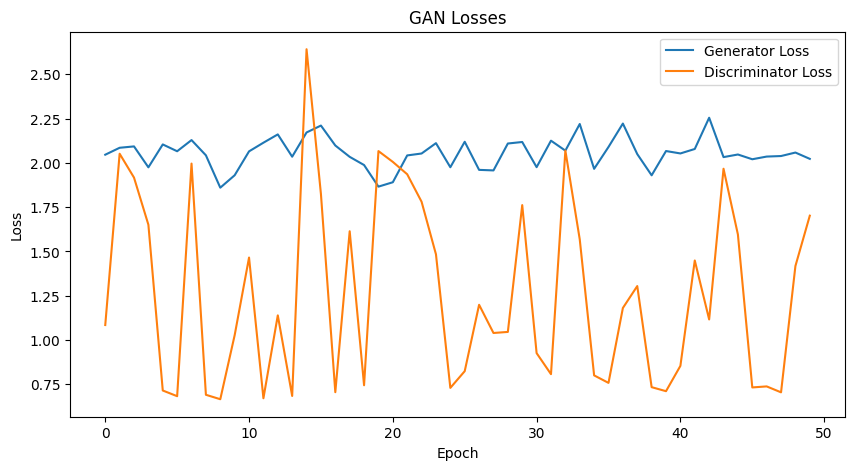

Sample generation and GAN training complete. Generated samples saved to 'gan_result.csv'.


In [8]:
if __name__ == "__main__":
    cwd = os.getcwd()
    data_dir = os.path.join(cwd, "gan_dataset")

    # Load and preprocess the data
    data, scaler = load_data(data_dir)
    batch_size = 128
    data_loader = DataLoader(TensorDataset(data), batch_size=batch_size, shuffle=True)

    # Extract column names before converting the DataFrame to a Tensor
    column_names = [col.strip() for col in pd.read_csv(os.path.join(data_dir, os.listdir(data_dir)[0])).columns if col != ' Label']

    # GAN parameters
    input_dim = 100
    output_dim = data.size(1)
    lr_g = 0.0002
    lr_d = 0.0004
    d_steps = 3
    epochs = 50

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    generator = Generator(input_dim, output_dim).to(device)
    discriminator = Discriminator(output_dim).to(device)

    # Train the GAN
    trained_generator, trained_discriminator, g_losses, d_losses = train_gan(
        generator, discriminator, data_loader, epochs, device, input_dim, lr_g, lr_d, d_steps
    )

    # Save and load models
    save_models(trained_generator, trained_discriminator, "generator.pth", "discriminator.pth")
    loaded_generator, loaded_discriminator = load_models(generator, discriminator, "generator.pth", "discriminator.pth")

    # Generate synthetic samples
    num_samples = 1000
    generated_samples = generate_samples(loaded_generator, num_samples, input_dim, device)

    # Convert generated samples to DataFrame
    generated_df = pd.DataFrame(generated_samples.detach().cpu().numpy())

    # Inverse transform the generated samples to their original scale
    inverse_transformed_samples = scaler.inverse_transform(generated_df)
    inverse_transformed_df = pd.DataFrame(inverse_transformed_samples)

    # Assign the extracted column names to the inverse transformed DataFrame
    inverse_transformed_df.columns = column_names

    # Ensure no negative values and convert to integers where appropriate
    inverse_transformed_df = inverse_transformed_df.clip(lower=0)
    integer_columns = [
        'Destination Port', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd PSH Flags', 'Bwd PSH Flags',
        'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'FIN Flag Count', 'SYN Flag Count',
        'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count'
    ]

    inverse_transformed_df[integer_columns] = inverse_transformed_df[integer_columns].round().astype(int)

    # Save the generated samples to a CSV file
    inverse_transformed_df.to_csv('gan_result.csv', index=False)

    # Plot the losses
    plot_losses(g_losses, d_losses)

    print("Sample generation and GAN training complete. Generated samples saved to 'gan_result.csv'.")
